<a href="https://colab.research.google.com/github/TaruSora/NLP_100knock/blob/main/100knock_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2022-03-15 02:29:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  11.6MB/s    in 2.4s    

2022-03-15 02:29:57 (11.6 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
!sed -e 's/"/'\''/g' newsCorpora.csv > newsCorpora_re.csv

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 13.4 MB/s 
     |████████████████████████████████| 81 kB 8.6 MB/s 
     |████████████████████████████████| 210 kB 82.4 MB/s 
     |████████████████████████████████| 78 kB 5.5 MB/s 
     |████████████████████████████████| 113 kB 85.7 MB/s 
     |████████████████████████████████| 150 kB 35.4 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=cfdbc2836316ee2d74405ae235f64bbd9270e02c0f8dad255222e01d0de88917
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


50.News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ

In [ ]:
# 50 データの入手・整形

import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

train, tmp = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['CATEGORY'])
valid, test = train_test_split(tmp, test_size=0.5, shuffle=True, random_state=42, stratify=tmp['CATEGORY'])

train.to_csv('train.txt', sep='\t', index=False)
valid.to_csv('valid.txt', sep='\t', index=False)
test.to_csv('test.txt', sep='\t', index=False)

print('学習用データ')
print(train['CATEGORY'].value_counts())
print('評価用データ')
print(valid['CATEGORY'].value_counts())
print('テスト用データ')
print(test['CATEGORY'].value_counts())

学習用データ
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
評価用データ
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
テスト用データ
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


51.学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．

In [ ]:
import string
import re

def preprocessing(text):
    code_regex = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]')
    text = code_regex.sub('', text) # textから記号を除去
    text = text.lower() # textを小文字に
    text = re.sub(r'\d+', '0', text) # text内の数字を0に
    return text
    
# データの再結合
df = pd.concat([train, valid, test], axis=0)
df.reset_index(drop=True, inplace=True)

# 前処理の実施
df['TITLE'] = df['TITLE'].map(lambda x: preprocessing(x))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# データの分割
train_valid = df[:len(train) + len(valid)]
test = df[len(train) + len(valid):]

# TfidfVectorizer
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

# ベクトル化
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE'])
X_test = vec_tfidf.transform(test['TITLE'])

# ベクトルをデータフレームに変換
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names())

# データの分割
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]

# データの保存
X_train.to_csv('./X_train.txt', sep='\t', index=False)
X_valid.to_csv('./X_valid.txt', sep='\t', index=False)
X_test.to_csv('./X_test.txt', sep='\t', index=False)

print(X_train.head())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


   0apple  0argentina  0bank  0bank of  0brent  0china   0d  0day  0ecb  0gm  \
0     0.0         0.0    0.0       0.0     0.0     0.0  0.0   0.0   0.0  0.0   
1     0.0         0.0    0.0       0.0     0.0     0.0  0.0   0.0   0.0  0.0   
2     0.0         0.0    0.0       0.0     0.0     0.0  0.0   0.0   0.0  0.0   
3     0.0         0.0    0.0       0.0     0.0     0.0  0.0   0.0   0.0  0.0   
4     0.0         0.0    0.0       0.0     0.0     0.0  0.0   0.0   0.0  0.0   

   ...  you can  you need  you to  young  your  your mother  yuan  zac  \
0  ...      0.0       0.0     0.0    0.0   0.0          0.0   0.0  0.0   
1  ...      0.0       0.0     0.0    0.0   0.0          0.0   0.0  0.0   
2  ...      0.0       0.0     0.0    0.0   0.0          0.0   0.0  0.0   
3  ...      0.0       0.0     0.0    0.0   0.0          0.0   0.0  0.0   
4  ...      0.0       0.0     0.0    0.0   0.0          0.0   0.0  0.0   

   zac efron      zone  
0        0.0  0.000000  
1        0.0  0.330221  

52.51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ.

In [ ]:
# 52 学習

from sklearn.linear_model import LogisticRegression

y_train = train['CATEGORY']
y_test = test['CATEGORY']
lg = LogisticRegression(random_state=42, max_iter=10000)
lg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

53.52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [ ]:
# 53 予測

import numpy as np

def lg_score(lg, X):
    return [np.max(lg.predict_proba(X), axis=1), lg.predict(X)]

train_pred = lg_score(lg, X_train)
test_pred = lg_score(lg, X_test)

print(train_pred)

[array([0.84109114, 0.98716601, 0.97387822, ..., 0.75299565, 0.8692011 ,
       0.70576088]), array(['b', 'b', 'b', ..., 'e', 'b', 'b'], dtype=object)]


54.52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [ ]:
# 54 正解率の計測

from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, train_pred[1])
print('学習データの正解率:', train_acc)
test_acc = accuracy_score(y_test, test_pred[1])
print('評価データの正解率:', test_acc)

学習データの正解率: 0.9169786596780232
評価データの正解率: 0.8854790419161677


55.52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [ ]:
# 55 混同行列の作成

from sklearn.metrics import confusion_matrix

# 学習データの混同行列
train_matrix = confusion_matrix(y_train, train_pred[1])
print(train_matrix)
print('\n')

# 評価データの混同行列
test_matrix = confusion_matrix(y_test, test_pred[1])
print(test_matrix)

[[4332  107   13   49]
 [  61 4165    1    8]
 [ 106  130  478   14]
 [ 241  150    7  822]]


[[532  22   2   7]
 [ 15 515   0   0]
 [ 20  25  45   1]
 [ 41  18   2  91]]


In [ ]:
# 直感的な理解のための図示

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(train_matrix, annot=True, cbar=True, square=True, cmap='Blues')
plt.show()
sns.heatmap(test_matrix, annot=True, cbar=True, square=True, cmap='Blues')
plt.show()

NameError: ignored

56.52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [ ]:
# 56 適合率，再現率，F1スコアの計測

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# 適合率
precision = precision_score(y_test, test_pred[1], average=None)
precision = np.append(precision, precision_score(y_test, test_pred[1], average='micro'))
precision = np.append(precision, precision_score(y_test, test_pred[1], average='macro'))

# 再現率
recall = precision_score(y_test, test_pred[1], average=None)
recall = np.append(recall, recall_score(y_test, test_pred[1], average='micro'))
recall = np.append(recall, recall_score(y_test, test_pred[1], average='macro'))

# F1
f1 = precision_score(y_test, test_pred[1], average=None)
f1 = np.append(f1, f1_score(y_test, test_pred[1], average='micro'))
f1 = np.append(f1, f1_score(y_test, test_pred[1], average='macro'))

# データフレームに変換
scores = [precision, recall, f1]
df_scores = pd.DataFrame(scores)
df_scores.columns = ['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均']
df_scores.index = ['適合率', '再現率', 'F1']
df_scores

,b,e,t,m,マイクロ平均,マクロ平均
適合率,0.875,0.887931,0.918367,0.919192,0.885479,0.900123
再現率,0.875,0.887931,0.918367,0.919192,0.885479,0.752456
F1,0.875,0.887931,0.918367,0.919192,0.885479,0.801127


57.52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [ ]:
# 57 特徴量の重みの確認

features = X_train.columns.values
rank = [i for i in range(1,11)]
for c, coef in zip(lg.classes_, lg.coef_):
    print('カテゴリ：', c)
    best = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重みの高い特徴量'], index=rank).T
    worst = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重みの低い特徴量'], index=rank).T
    ranking = pd.concat([best, worst], axis=0)
    display(ranking)
    print('\n')

カテゴリ： b


,1,2,3,4,5,6,7,8,9,10
重みの高い特徴量,fed,ecb,bank,oil,china,ukraine,stocks,euro,obamacare,ipo
重みの低い特徴量,her,video,ebola,aereo,and,star,drug,the,study,she




カテゴリ： e


,1,2,3,4,5,6,7,8,9,10
重みの高い特徴量,chris,kardashian,movie,film,kim,her,star,wedding,paul,trailer
重みの低い特徴量,update,us,google,study,billion,says,data,ceo,risk,gm




カテゴリ： m


,1,2,3,4,5,6,7,8,9,10
重みの高い特徴量,ebola,cancer,drug,study,mers,fda,health,cdc,medical,cases
重みの低い特徴量,facebook,ceo,gm,climate,deal,twitter,sales,apple,bank,profit




カテゴリ： t


,1,2,3,4,5,6,7,8,9,10
重みの高い特徴量,google,facebook,apple,climate,microsoft,tmobile,googles,gm,heartbleed,nasa
重みの低い特徴量,drug,cancer,fed,american,high,but,her,percent,ukraine,stocks


58.異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [ ]:
# 58 正則化パラメータの変更

result = []
for C in np.logspace(-5, 4, 10, base=10):
    # 学習
    lg = LogisticRegression(random_state=42, max_iter=10000, C=C)
    lg.fit(X_train, y_train)
    # 予測
    train_pred = lg_score(lg, X_train)
    valid_pred = lg_score(lg, X_valid)
    test_pred = lg_score(lg, X_test)
    # 正解率
    train_acc = accuracy_score(train['CATEGORY'], train_pred[1])
    valid_acc = accuracy_score(valid['CATEGORY'], valid_pred[1])
    test_acc = accuracy_score(test['CATEGORY'], test_pred[1])

    result.append([C, train_acc, valid_acc, test_acc])

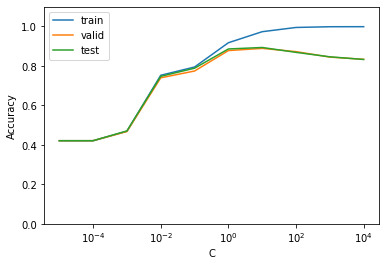

In [ ]:
# データの可視化

result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

59.学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [ ]:
# 59 ハイパーパラメータの探索

import optuna 

def objective(trial):
    x = trial.suggest_uniform('x', 0, 1) # 正則化のバランス
    C = trial.suggest_uniform('C', 1e-4, 1e4) # 正則化の強さ
    
    # モデルの学習
    lg = LogisticRegression(random_state=123, 
                            max_iter=10000, 
                            penalty='elasticnet', 
                            solver='saga', 
                            l1_ratio=x, 
                            C=C)
    lg.fit(X_train, y_train)
    # 予測値
    valid_pred = lg_score(lg, X_valid)
    # 正解率
    valid_acc = accuracy_score(valid['CATEGORY'], valid_pred[1])

    return valid_acc

# インスタンスの作成
study = optuna.create_study(direction='maximize') # valid_acc（正解率）を最大化したい
study.optimize(objective, timeout=3600)

# 結果の確認
best_trial = study.best_trial
print('best_value:', best_trial.value)
print('bast_params:')
for key, value in best_trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2022-03-14 04:14:09,809] Trial 0 finished with value: 0.8360778443113772 and parameters: {'x': 0.8369945279146238, 'C': 5273.31607583886}. Best is trial 0 with value: 0.8360778443113772.


best_value: 0.8360778443113772
bast_params:
    x: 0.8369945279146238
    C: 5273.31607583886


In [ ]:
# パラメータの設定
l1_ratio = best_trial.params['x']
C = best_trial.params['C']

# モデルの学習
lg = LogisticRegression(random_state=123, 
                        max_iter=10000, 
                        penalty='elasticnet', 
                        solver='saga', 
                        l1_ratio=l1_ratio, 
                        C=C)
lg.fit(X_train, train['CATEGORY'])

# 予測値の取得
train_pred = lg_score(lg, X_train)
valid_pred = lg_score(lg, X_valid)
test_pred = lg_score(lg, X_test)

# 正解率の算出
train_acc = accuracy_score(train['CATEGORY'], train_pred[1]) 
valid_acc = accuracy_score(valid['CATEGORY'], valid_pred[1]) 
test_acc = accuracy_score(test['CATEGORY'], test_pred[1])

print('正解率(学習用):', train_acc)
print('正解率(検証用):', valid_acc)
print('正解率(評価用):', test_acc)

正解率(学習用): 0.9981280419318608
正解率(検証用): 0.8360778443113772
正解率(評価用): 0.8390718562874252


In [ ]:
# アルゴリズム選択検証

from sklearn.utils import all_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import warnings

allAlgorithms = all_estimators(type_filter = 'classifier')

warnings.filterwarnings('ignore')

kfold_cv = KFold(n_splits = 5, shuffle = True)

for(name, algorithm) in allAlgorithms:
    try:
        clf = algorithm()
        
        if hasattr(clf,"score"):
            scores = cross_val_score(clf, X_train, y_train, cv = kfold_cv)
        print(name, "の正解率")
        print(scores)

    except Exception:
        pass

AdaBoostClassifier の正解率
[0.64248947 0.63313056 0.6499766  0.6499766  0.64981273]
BaggingClassifier の正解率
[0.75292466 0.75573234 0.73888629 0.76041179 0.75702247]
BernoulliNB の正解率
[0.86008423 0.85727656 0.87131493 0.85727656 0.86470037]
CalibratedClassifierCV の正解率
[0.86616752 0.87505849 0.88769303 0.88769303 0.88857678]
CategoricalNB の正解率
[nan nan nan nan nan]
ComplementNB の正解率
[0.87225082 0.88628919 0.87318671 0.88675714 0.86985019]
DecisionTreeClassifier の正解率
[0.70800187 0.70472625 0.7267197  0.72063641 0.73174157]
DummyClassifier の正解率
[0.40804867 0.42021526 0.42115115 0.42302293 0.43398876]
ExtraTreeClassifier の正解率
[0.74122602 0.77023865 0.76275152 0.76321947 0.76685393]
ExtraTreesClassifier の正解率
[0.85493683 0.85540477 0.82779598 0.83294338 0.84784644]
GaussianNB の正解率
[0.80065512 0.77351427 0.7810014  0.80954609 0.78417603]
GaussianProcessClassifier の正解率
[0.8137576  0.82452036 0.82124474 0.82686008 0.83473783]
GradientBoostingClassifier の正解率
[0.78802059 0.80065512 0.79082826 0.8006551